In [72]:
import os
import numpy as np

import torch
import torch.nn as nn
from torchvision.models import vgg19
from torch.autograd import Variable
import torch.cuda
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from PIL import Image

In [73]:
# Use cuda
cuda = torch.cuda.is_available()

In [74]:
height =64
weight = 64
# Load a image and transfer it to torch.tensor format
img_transform = transforms.Compose(
            [
                transforms.Resize((height, width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5),
            ]
        )

img = Image.open('/home/ubuntu/super_resolution/PyTorch-GAN/implementations/srgan/images/noscale_change/4199.png')
img_1 = img_transform(img)
np.shape(img_1)

/home/ubuntu/anaconda3/envs/srgan/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([3, 64, 64])

In [89]:
# First let's have a view of the whole structure of vgg19
model = vgg19(pretrained=True)
feature = torch.nn.Sequential(*list(model.children())[:])
print(feature)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [75]:
# Define vgg19 feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18]) 

    def forward(self, img):
        return self.feature_extractor(img)

In [71]:
feature_extractor = FeatureExtractor()
print(feature_extractor)
# Set feature extractor to inference mode
feature_extractor.eval()
if cuda:
    feature_extractor = feature_extractor.cuda()


FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3

In [76]:
# Transfer the image to torch.cuda.tensor format to use cuda (if cuda is not used, then delete related code where cuda is used)
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
img_1 = img_1.type(Tensor)
img_1.size()

torch.Size([3, 64, 64])

In [77]:
# Generate features
gen_features = feature_extractor(img_1)
features_np = gen_features.data.cpu().numpy()
print(np.shape(features_np))
features_np

(256, 16, 16)


array([[[ 2.8570123 ,  5.1582346 ,  0.        , ...,  0.        ,
          7.154669  ,  3.8342776 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  2.1093996 ,  0.        , ...,  4.0085654 ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  3.2775705 ,  0.        , ...,  0.        ,
          3.4646087 ,  2.2055607 ]],

       [[ 4.258561  ,  7.0497346 ,  8.959111  , ...,  6.6810145 ,
          0.        ,  0.        ],
        [ 0.8314683 ,  6.093964  , 11.307572  , ...,  8.8576145 ,
          0.        ,  0.        ],
        [ 4.1255684 ,  6.1892853 , 17.301373  , ..., 26.727179  ,
         15.187721  ,  9.370935  ],
        ...,
        [ 9.011142  ,  3.472573  ,  8.085909  , ..., 1

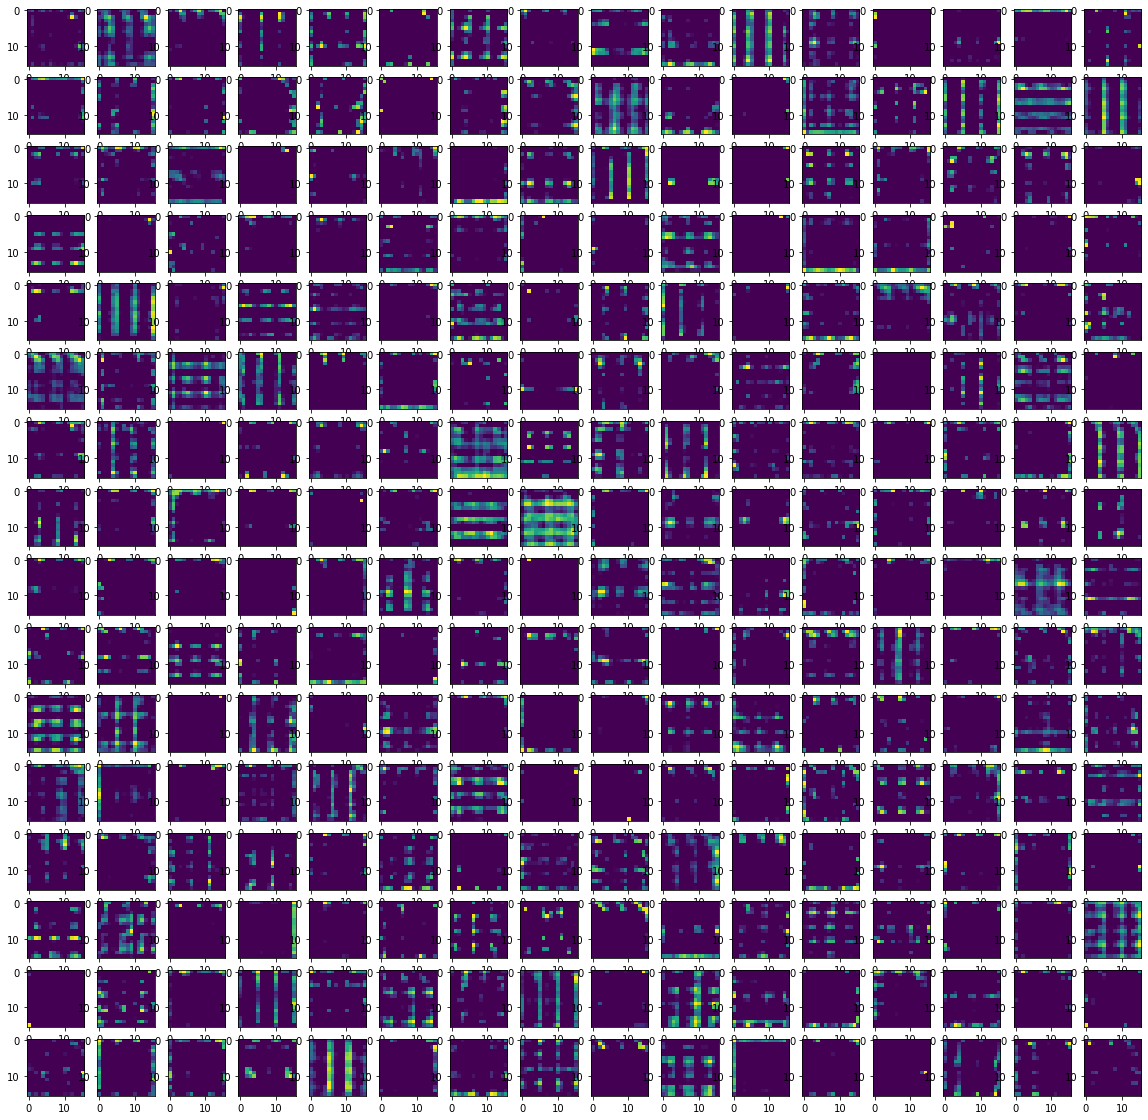

In [84]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(16,16,figsize = (20,20))
z = 0
for i in range(16):
    for j in range (16):
        axs[i,j].imshow(features_np[z])
        z += 1